# Scenario C: The Two-Putt Challenge

Goal: Two distinct shots to get from $(0,0)$ to $(4.5, 3.4)$.
Shot 1: Go through midpoint $(2.6, 1)$ and come to a "stop" (speed $10^{-3}$ m/s).
Shot 2: From that stopping point, go through midpoint $(4, 3.8)$ and end at the hole.

In [16]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
from surfaces import ScenarioC
from physics import PhysicsEngine
from solver import ShootingSolver
from utils import plot_trajectory

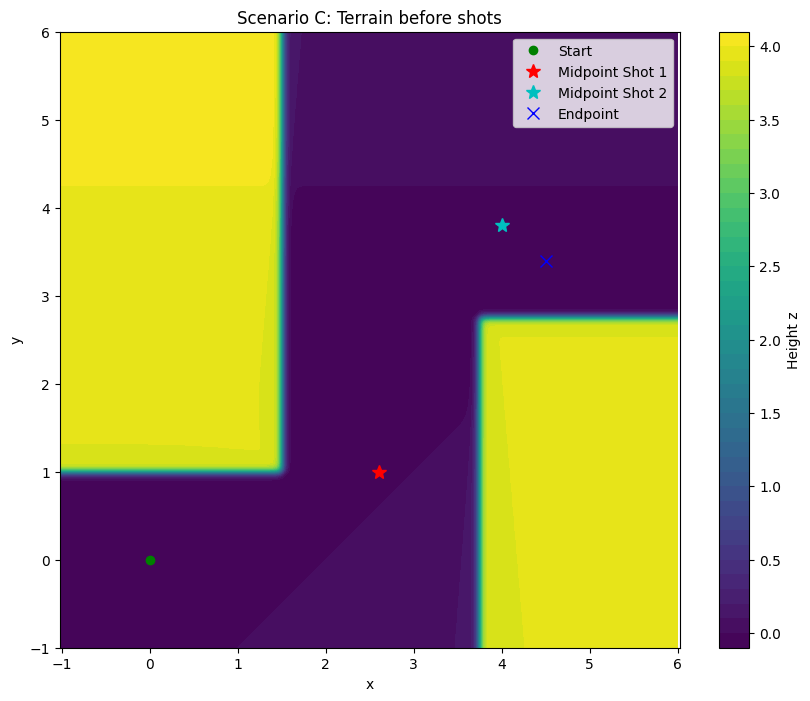

In [23]:
# Plot terrain for Scenario C before any shots
surface = ScenarioC()
x_range = np.linspace(-1, 6, 300)
y_range = np.linspace(-1, 6, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = surface.height(X, Y)

plt.figure(figsize=(10, 8))
cs = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(cs, label='Height z')
plt.title('Scenario C: Terrain before shots')
plt.xlabel('x')
plt.ylabel('y')
# Mark start and common midpoints/targets
plt.plot(0, 0, 'go', label='Start')
plt.plot(2.6, 1.0, 'r*', markersize=10, label='Midpoint Shot 1')
plt.plot(4.0, 3.8, 'c*', markersize=10, label='Midpoint Shot 2')
plt.plot(4.5, 3.4, 'bx', markersize=8, label='Endpoint')
plt.legend()
plt.axis('equal')
plt.show()

In [22]:
surface = ScenarioC()
physics = PhysicsEngine(surface)
solver = ShootingSolver(physics)

# Physics check: can the ball stop at the target midpoint physically?
grad = surface.gradient(3.2, 1.0)
slope_mag = np.linalg.norm(grad)
friction_limit = physics.mu

print(f"Slope magnitude at midpoint: {slope_mag:.4f}")
print(f"Friction coefficient: {friction_limit}")

if slope_mag > friction_limit:
    print("WARNING: Ball cannot stop statically at this midpoint!")

# Shot 1
target_pos_1 = np.array([3.2, 1.0])
target_speed_1 = 1e-3

def objective_shot1(params):
    vx0, vy0, T = params
    if T <= 0:
        return [100, 100, 100]
        
    initial_state = [0, 0, vx0, vy0]
    sol = solver.integrate(initial_state, [0, T])
    
    xf, yf, vxf, vyf = sol.y[:, -1]
    
    grad = surface.gradient(xf, yf)
    vzf = vxf * grad[0] + vyf * grad[1]
    vf = np.sqrt(vxf**2 + vyf**2 + vzf**2)
    
    return [xf - target_pos_1[0], yf - target_pos_1[1], vf - target_speed_1]

guess1 = [2.0, 1.0, 2.0]
sol1 = solver.solve(objective_shot1, guess1)

print("Shot 1 Solution:", sol1.x)
print("Success:", sol1.success)

Slope magnitude at midpoint: 0.2113
Friction coefficient: 0.075
Shot 1 Solution: [1.97796258 1.26969498 2.17182866]
Success: False
Shot 1 Solution: [1.97796258 1.26969498 2.17182866]
Success: False


In [ ]:
if sol1.success:
    vx0, vy0, T = sol1.x
    initial_state = [0, 0, vx0, vy0]
    sol_path1 = solver.integrate(initial_state, [0, T])
    plot_trajectory(surface, sol_path1, title="Shot 1")
    
    start_pos_2 = sol_path1.y[:2, -1]
    print(f"Stopping Point: {start_pos_2}")
else:
    start_pos_2 = target_pos_1 # Fallback for testing logic

In [ ]:
# Shot 2
midpoint_2 = np.array([4.0, 3.8])
endpoint_2 = np.array([4.5, 3.4])

def objective_shot2(params):
    vx0, vy0, T1, T2 = params
    if T1 <= 0.1 or T2 <= T1 + 0.1:
        return [100, 100, 100, 100]
        
    initial_state = [start_pos_2[0], start_pos_2[1], vx0, vy0]
    
    from scipy.integrate import solve_ivp
    sol = solve_ivp(
        physics.equations_of_motion,
        [0, T2],
        initial_state,
        rtol=1e-8, atol=1e-8,
        dense_output=True
    )
    
    if not sol.success:
        return [100, 100, 100, 100]

    state_T1 = sol.sol(T1)
    state_T2 = sol.sol(T2)
    
    return [
        state_T1[0] - midpoint_2[0],
        state_T1[1] - midpoint_2[1],
        state_T2[0] - endpoint_2[0],
        state_T2[1] - endpoint_2[1]
    ]

guess2 = [1.0, 1.0, 1.0, 2.0]
sol2 = solver.solve(objective_shot2, guess2)

print("Shot 2 Solution:", sol2.x)
print("Success:", sol2.success)

Shot 2 Solution: [0.94948907 1.94593475 1.16610205 1.27024501]
Success: False


In [ ]:
if sol2.success:
    vx0, vy0, T1, T2 = sol2.x
    initial_state = [start_pos_2[0], start_pos_2[1], vx0, vy0]
    sol_path2 = solver.integrate(initial_state, [0, T2])
    plot_trajectory(surface, sol_path2, title="Shot 2")